In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [13]:
import platform

def plot_model_hist(model,test=False):

    """
    Will plot the model history for the loss and accuracy
    """
    fig,ax = plt.subplots()
    # calling the keras history object to get the loss and accuracy
    ax.plot(model.history.history['loss'],label='loss',linewidth=5)
    ax.set_title('Loss (MAE)',fontsize=30)
    ax.set_ylabel('Loss',fontsize=30)
    ax.set_xlabel('Epochs',fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=25)

    
    
    return fig,ax 
#%%
#in_fol = '/home/nmathewa/main/GIT/tropcyc/atlantic_exps2/preprocessing/'

if platform.system() == 'Darwin':
    in_fol = '/Volumes/nma_backup/Datasets/Other_works/tropcyc/atlantic_exps2/preprocessing/'
else : 
    in_fol = '/Volumes/New Volume/Other_works/tropcyc/atlantic_exps2/preprocessing/'



In [4]:

x_data = np.load(in_fol+'final_arr.npy')

y_speeds = pd.read_csv(in_fol+'targets.csv')['USA_WIND'].to_numpy()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_speeds, test_size=0.2, random_state=1)



from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#train_y_new = scaler.fit_transform(y_train)


import matplotlib.pyplot as plt


max_vals = []
min_vals = []

for ii in range(x_train.shape[-1]):
    max_vals += [x_train[:,:,:,ii].max()]
    min_vals += [x_train[:,:,:,ii].min()]




norm_x_train = (x_train - min_vals)/(np.array(max_vals) - np.array(min_vals))

#norm_y_train = (y_train - y_train.mean())/y_train.std()

norm_y_train = (y_train - y_train.min())/(y_train.max() - y_train.min())

max_vals = []
min_vals = []

for jj in range(x_test.shape[-1]):
    max_vals += [x_test[:,:,:,jj].max()]
    min_vals += [x_test[:,:,:,jj].min()]


norm_x_test = (x_test - min_vals)/(np.array(max_vals) - np.array(min_vals))

#norm_y_train = (y_train - y_train.mean())/y_train.std()

norm_y_test = (y_test - y_test.min())/(y_test.max() - y_test.min())

In [11]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l1_l2
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

model = Sequential()
#
model.add(Conv2D(filters = 10, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (10,10,5)))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
#model.add(Dropout(0.25))
# fully connected

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

model.add(Dropout(0.25))



model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "relu"))



callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=4)

model.compile(optimizer='adam' , loss = "mae", metrics=["accuracy"])        
model.fit(norm_x_train,norm_y_train,epochs=100,callbacks=[callback])

Epoch 1/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1713 - accuracy: 8.8849e-04
Epoch 2/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1307 - accuracy: 0.0013
Epoch 3/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1151 - accuracy: 0.0018
Epoch 4/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1099 - accuracy: 0.0022
Epoch 5/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1058 - accuracy: 0.0024
Epoch 6/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1016 - accuracy: 0.0013
Epoch 7/100
141/141 [==============================] - 1s 6ms/step - loss: 0.1011 - accuracy: 0.0024
Epoch 8/100
141/141 [==============================] - 1s 6ms/step - loss: 0.1004 - accuracy: 0.0018
Epoch 9/100
141/141 [==============================] - 1s 6ms/step - loss: 0.0975 - accuracy: 0.0016
Epoch 10/100
141/141 [==============================] - 1s 6ms/step - loss: 0.0980 - ac

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Loss (MAE)'}, xlabel='Epochs', ylabel='Loss'>)

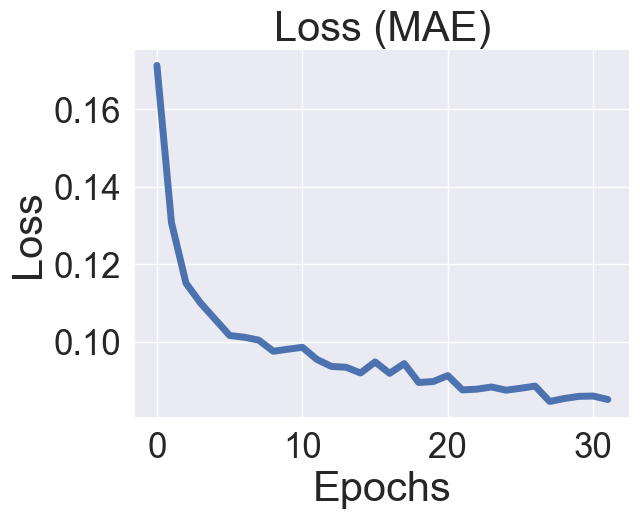

In [14]:
import seaborn as sbs
sbs.set_theme()
plot_model_hist(model)


In [15]:
targets = model.predict(norm_x_test)


36/36 [==============================] - 0s 2ms/step


In [16]:
new_targets = targets*(y_test.max() - y_test.min()) + y_test.min()


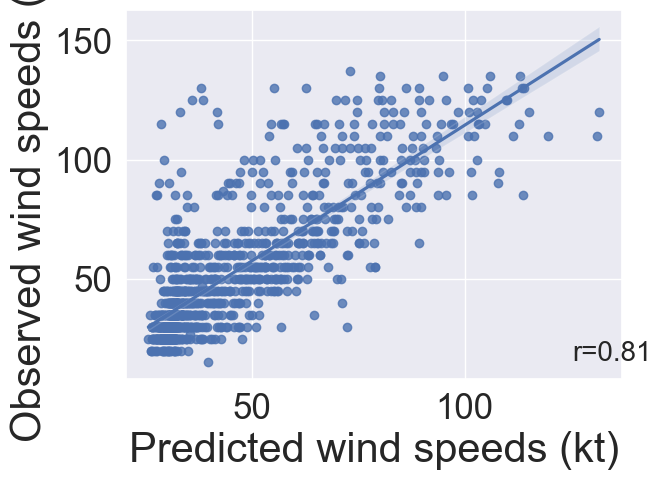

In [18]:
test = pd.DataFrame(new_targets,columns=['predicted'])
test['true'] = y_test

test.corr()


fig,ax = plt.subplots()
sbs.regplot(test,x='predicted',y='true',ax=ax)


import numpy as np
mae_mean = abs(test['true'] - test['predicted'])
import scipy as sp

r,p = sp.stats.pearsonr(test['predicted'], test['true'])

ax.text(.9, 0.05, 'r={:.2f}'.format(r),
            transform=ax.transAxes,fontsize=20)

ax.set_ylabel('Observed wind speeds (kt)',fontsize=30)
ax.set_xlabel('Predicted wind speeds (kt)',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
